In [8]:
import numpy as np
import pandas as pd
import io,os, bson,pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.data import imread 
import tensorflow as tf
print('All modules imported.')

All modules imported.


In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [10]:
data = bson.decode_file_iter(open('data/train_example.bson','rb'))

features= []
labels=[]
for c,d in enumerate(data):
    categoryid=d['category_id']
    for e,pic in enumerate(d['imgs']):
        picture = imread(io.BytesIO(pic['picture']))
        features.append(picture)
        labels.append(categoryid)
features = np.array(features)
labels=np.array(labels)
    

In [11]:
print('Total number of images : {}'.format(len(features)))
print('Total number of categories : {}'.format(len(labels)))

print('Total number of unique categories : {}'.format(len(set(labels))))

Total number of images : 110
Total number of categories : 110
Total number of unique categories : 36


sample image


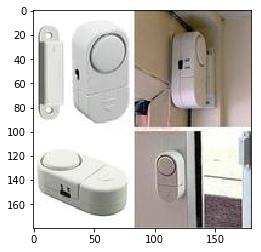

In [12]:
print("sample image")
plt.imshow(features[4],cm.binary)

In [13]:
def normalize(image_data):
    X= image_data
    Xmin = np.amin(image_data)
    Xmax = np.amax(image_data)
    
    Xscale = (X-Xmin)/(Xmax-Xmin)
    
    return Xscale
features = normalize(features)
print(features[1])

[[[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 ..., 
 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]

 [[ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  ..., 
  [ 1.  1.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  1.]]]


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

In [15]:
one_hot_enc= LabelBinarizer()
labels= one_hot_enc.fit_transform(labels)
print(labels.shape)
print('Labels One-Hot Encoded')




(110, 36)
Labels One-Hot Encoded


In [16]:
train_features, valid_features, train_labels, valid_labels = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=123456)
print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [17]:
#save train & validation images locally
pickle_file='cdiscount.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to a pickle file')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


In [134]:
#CHECKPOINT

%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'cdiscount.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']

  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


In [135]:
x = tf.placeholder(tf.float32,shape=(None,180,180,3),name='input')
y= tf.placeholder(tf.float32,shape=(None, 36),name='label')
keep_prob = tf.placeholder(tf.float32,shape=None,name='keep_prob')


In [136]:
initializer= tf.contrib.layers.xavier_initializer_conv2d()
conv_ksize=(3,3)
conv_strides=(4,4)
color_channels=3
conv_num_outputs=32
pool_ksize=(2,2)
pool_strides=(2,2)
weights = tf.Variable(initializer(shape=[*conv_ksize, int(color_channels), conv_num_outputs]))
bias = tf.Variable(tf.zeros(conv_num_outputs))
    
# Apply Convolution
conv_net = tf.nn.conv2d(x, weights, strides=[1,*conv_strides,1], padding='SAME')
# Add bias
conv_net = tf.nn.bias_add(conv_net, bias)
# Apply activation function
conv_net= tf.nn.relu(conv_net)
    
conv_net = tf.nn.max_pool(conv_net,ksize=[1, *pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')







In [137]:
#flatten 4-D tensor to 2-D tensor
conv_net = tf.contrib.layers.flatten(conv_net)


In [138]:
initializer= tf.contrib.layers.xavier_initializer_conv2d()
weights = tf.Variable(initializer([conv_net.get_shape().as_list()[1],36]))
bias = tf.Variable(tf.zeros(36))
fc = tf.add(tf.matmul(conv_net,weights),bias)
logits = tf.nn.relu(fc)


In [139]:
# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [143]:
 # TODO: Tune Parameters
epochs = 10
batch_size = 110
keep_probability = 0.4


In [144]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        print(features[start:end].shape)
    return features[start:end], labels[start:end]

In [145]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    batch_features, batch_labels = batch_features_labels(features, labels, batch_size)
    # Training cycle
    for epoch in range(epochs):
        sess.run(optimizer, feed_dict={ x: batch_features, y: batch_labels, keep_prob: keep_probability})
        print('Epoch {:>2}:  '.format(epoch + 1), end='')
        print('Cost: {:f}'.format(sess.run(cost, feed_dict={ x: batch_features, y: batch_labels,keep_prob:1})))
        print('Accuracy: {:f}'.format(sess.run(accuracy, feed_dict={ x: batch_features, y: batch_labels,keep_prob:1})))

Checking the Training on a Single Batch...
(110, 180, 180, 3)
Epoch  1:  Cost: 3.162895
Accuracy: 0.072727
Epoch  2:  Cost: 3.194892
Accuracy: 0.354545
Epoch  3:  Cost: 3.033917
Accuracy: 0.354545
Epoch  4:  Cost: 2.895256
Accuracy: 0.354545
Epoch  5:  Cost: 2.957358
Accuracy: 0.354545
Epoch  6:  Cost: 2.992280
Accuracy: 0.354545
Epoch  7:  Cost: 2.947232
Accuracy: 0.354545
Epoch  8:  Cost: 2.856041
Accuracy: 0.354545
Epoch  9:  Cost: 2.774381
Accuracy: 0.354545
Epoch 10:  Cost: 2.768863
Accuracy: 0.354545
